### Mining dataset Using bge-large-en

In [1]:
# !pip3 install orjson

In [2]:
import os
import pickle
from glob import glob
# import json
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import random
import orjson as json
import numpy as np
from scipy.spatial import KDTree
import seaborn as sns

In [3]:
class Pointer:
    def __init__(self, filename):
        self.filename = filename
        self.index = 0

    def _save(self):
        with open(self.filename, 'wb') as fopen:
            pickle.dump(self.index, fopen)

    def increment(self):
        self.index += 1
        self._save()

    def load(self):
        if not os.path.exists(self.filename):
            return
        with open(self.filename, 'rb') as fopen:
            self.index = pickle.load(fopen)

### Load json file containing embedding & texts

In [4]:
!ls bge-embedding/bge-large-en-embedding/

c.cari.com.my.jsonl	     malay-news.jsonl02.splitted
malay-news.jsonl00.splitted  malay-news.jsonl03.splitted
malay-news.jsonl01.splitted  malay-news.jsonl04.splitted


In [5]:
data = []

files = glob('bge-embedding/bge-large-en-embedding/malay-news.jsonl*.splitted')
for f in files:
    with open(f) as fopen:
        for x in tqdm(fopen):
            try:
                data.append(json.loads(x))
            except:
                pass

500000it [05:16, 1579.18it/s]
500000it [03:55, 2119.86it/s]
500000it [04:11, 1984.60it/s]
500000it [05:35, 1490.19it/s]
187464it [02:12, 1414.84it/s]


In [6]:
len(data)

2187464

In [7]:
data[0]

{'text': {'ms': 'Ia termasuk pematuhan sepenuhnya protokol IPC berkaitan lagu kebangsaan serta bendera dan penyediaan visa yang berkaitan, menurut kenyataan yang dikeluarkan di laman web rasminya, www.paralympic.org.',
  'en': 'It includes full compliance with IPC protocols regarding the national anthem and flag and related visa arrangements, according to a statement released on its official website, www.paralympic.org.'},
 'v': [-0.017401730928924466,
  -0.031004850915419036,
  -0.008700754186706332,
  0.049750785341982726,
  -0.003981594661886204,
  0.008986581561173688,
  0.0038944491188683257,
  0.0220226242468729,
  0.019141226482518203,
  0.008672966541375633,
  0.01384720899907564,
  -0.013710134047327337,
  -0.02835310701234797,
  -0.022740332305439925,
  -0.03727447060514027,
  0.009738356509868684,
  -0.028741655468959914,
  -0.007927320236003755,
  -0.013839967578193512,
  0.0033576322559417536,
  -0.0009372919104477601,
  0.021357004218165807,
  -0.07403324829579087,
  -0.0

**Dataset Format**

- v: contains the embedding vectors with 1024 dimension generated from baai/bge-large-en
- text:
    - 'left' : original text
    - 'en': translated english text
    - 'ms' : translated malay text

In [8]:
data[1]

{'text': {'ms': 'Terdapat tiga faktor utama yang dijadikan sandaran oleh GPI iaitu tahap keselamatan masyarakat, perkembangan konflik dalaman dan antarabangsa serta domain ketenteraan.',
  'en': 'There are three main factors relied on by the GPI, namely the level of community security, the development of internal and international conflicts and the military domain.'},
 'v': [0.005915354879542428,
  -0.014163089094350961,
  0.01853497874374684,
  -0.0032499079924866205,
  -0.07263560208486544,
  -0.03064726323776329,
  -0.02397192686451558,
  0.0021795935881048466,
  -0.0046417831219047415,
  0.01693693293136165,
  0.02727540989381663,
  -0.012195806155420305,
  -0.018443499936783986,
  -0.0741867653473922,
  -0.02862651915326836,
  0.04788676415218878,
  -0.038499439169002204,
  0.013639958215433642,
  0.03511861847680932,
  0.00318600738017507,
  0.033591656046471144,
  -0.014882460101319614,
  -0.0823062478532276,
  -0.005028642484932953,
  -0.027470815101625207,
  0.0638508524199220

### Scipy KDTree for Computing Distance & Fast Nearest Neighbor Lookup

In [9]:
vectors, texts = [], []

for d in data:
    vectors.append(d['v'])
    texts.append(d['text'])

In [10]:
from scipy.spatial import KDTree
import numpy as np

In [11]:
concat = np.array(vectors)
concat.shape

(2187464, 1024)

In [12]:
%%time

kd_tree = KDTree(concat, leafsize = 40)

CPU times: user 48.7 s, sys: 5.45 s, total: 54.1 s
Wall time: 54.3 s


In [13]:
%%time

dist, ind = kd_tree.query(concat[:5], k=len(concat), workers = 1)

CPU times: user 18.6 s, sys: 2.12 s, total: 20.8 s
Wall time: 21 s


In [16]:
dist.shape

(5, 2187464)

/tmp/ipykernel_3136111/1016762756.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dist[:2])
/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

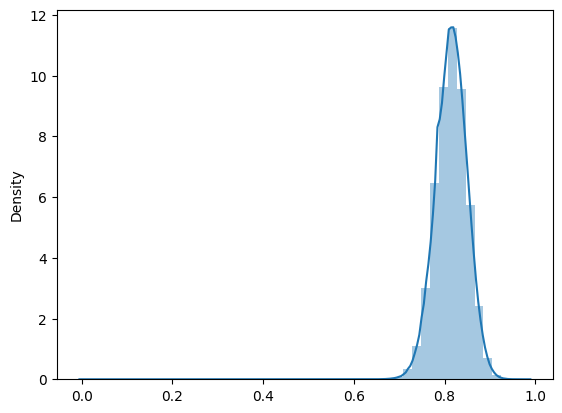

In [18]:
sns.distplot(dist[:2])

### Generating Train Dataset

we will generate three row for each index text:

{'query': text for one key , 'neg': negative pair for each text index for key ['left','en','ms'], 'pos': positive pair text and query text for text in key ['left','en','ms'] except the key used in the query]}


- Positive text pair threshold: text distance <= 10
- Negative text pair threshold: text distance > 15

In [19]:
keys = list(texts[0].keys())

In [20]:
keys

['ms', 'en']

In [21]:
texts[0].keys()

dict_keys(['ms', 'en'])

In [22]:
# !wget https://gist.githubusercontent.com/huseinzol05/98974ae8c6c7a65d4bc0af9f5003786a/raw/5aa5257608b61e8fcc828e99fbd070d5ca7358e3/mp.py
import mp

def dedup(strings):
    unique_neg = []
    elements = set()

    for n in strings:
        x_lower = n.lower()
        if x_lower not in elements:
            elements.add(x_lower)
            unique_neg.append(n)
    return unique_neg

dedup(['a', 'a'])

['a']

In [23]:
!mkdir malay-news

In [33]:
import time

lower_bound = 0.6
upper_bound = 0.9

def loop(data):
    data, index = data
    filename = f'malay-news/train-dataset-{index}.jsonl'
    pointer = Pointer(f'{filename}.pickle')
    pointer.load()
    with open(filename, 'a') as fopen:
        for i, x in tqdm(enumerate(data)):
            if i > pointer.index:
                dist, ind = kd_tree.query(concat[x], k=len(concat), workers = 1)

                for key in keys:

                    query = texts[x][key]

                    pos_indices = [k for k in ind[dist <= lower_bound]]
                    neg_indices = [k for k in ind[dist > upper_bound]]

                    if len(neg_indices) > 5:
                        neg_indices = random.sample(neg_indices,5)
                    if len(pos_indices) > 5:
                        rand_pos = random.sample(pos_indices,4)
                        rand_pos.append(x)
                        pos_indices = rand_pos


                    pos = [value for i in pos_indices for value in texts[i].values() if value != query ]

                    if len(dedup(pos)) == 0:
                        continue

                    neg = [value for i in neg_indices for value in texts[i].values()]

                    if len(dedup(neg)) == 0:
                        continue


                    d = {'query':query,'pos':dedup(pos),'neg':dedup(neg)}
                    fopen.write(f'{json.dumps(d).decode()}\n')
                    fopen.flush()
                    pointer.index = i
                    pointer._save()

In [34]:
!rm malay-news/*

In [35]:
# loop((range(10), 0))

In [ ]:
import mp

mp.multiprocessing(range(len(data)), loop, cores = 45, returned = False)

1284it [3:16:21,  8.35s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2855it [7:06:02,  9.74s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

3141it [7:45:43,  8.65s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000

13176it [33:16:41,  8.80s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

13496it [33:52:50,  9.45s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

13997it [34:34:01,  9.44s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limi

35019it [86:40:17,  9.70s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

35172it [88:39:40, 10.11s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

37615it [92:57:54,  8.54s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limi